In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load the "Big" file (Animation Master)
df = pd.read_csv('../data/processed/master_animation_data.csv', low_memory=False)

print(f"Dataset Shape: {df.shape}")
print(f"Columns: {list(df.columns)}")

# 1. Check for Critical Nulls (Should be ZERO for these columns)
critical_cols = ['los_x', 'void_penalty', 'is_punished', 'damage_epa']
null_counts = df[critical_cols].isnull().sum()
print("\n--- Critical Null Check (Must be 0) ---")
print(null_counts)

# 2. Verify Filtering Logic (Should be Empty)
scrambles = df[df['dropback_type'].isin(['SCRAMBLE', 'SCRAMBLE_ROLLOUT'])]
man_coverage = df[df['team_coverage_man_zone'].str.contains('Man', na=False)]
print(f"\nScramble plays found (Should be 0): {len(scrambles)}")
print(f"Man Coverage plays found (Should be 0): {len(man_coverage)}")

# 3. Verify Coordinate Normalization (Offense should move Left -> Right)
# In standard tracking data, X=10 is left endzone, X=110 is right endzone.
# Most play starts (LOS) should be between 10 and 90.
print(f"\nMean LOS X: {df['los_x'].mean():.2f}")
print(f"Min LOS X: {df['los_x'].min()}")
print(f"Max LOS X: {df['los_x'].max()}")

Dataset Shape: (3091012, 49)
Columns: ['game_id', 'play_id', 'nfl_id', 'frame_id', 'play_direction', 'absolute_yardline_number', 'player_name', 'player_position', 'player_side', 'player_role', 'x', 'y', 's', 'a', 'dir', 'o', 'ball_land_x', 'ball_land_y', 'phase', 'week', 'home_team_abbr', 'visitor_team_abbr', 'play_description', 'down', 'yards_to_go', 'possession_team', 'defensive_team', 'yardline_number', 'play_nullified_by_penalty', 'pass_result', 'pass_length', 'route_of_targeted_receiver', 'play_action', 'dropback_type', 'pass_location_type', 'team_coverage_man_zone', 'team_coverage_type', 'yards_gained', 'expected_points_added', 'pre_snap_home_team_win_probability', 'los_x', 'zone_assignment', 'target_zone_x', 'target_zone_y', 'void_penalty', 'is_punished', 'damage_epa', 'drift_yards', 'dist_to_ball']

--- Critical Null Check (Must be 0) ---
los_x           0
void_penalty    0
is_punished     0
damage_epa      0
dtype: int64

Scramble plays found (Should be 0): 0
Man Coverage play

In [3]:
# Group by Play to get Summary Stats
play_summary = df.drop_duplicates(subset=['game_id', 'play_id'])
total_plays = len(play_summary)

# Count plays where AT LEAST ONE defender had a void penalty
void_plays = df[df['void_penalty'] == True]['play_id'].nunique()

print(f"Total Analyzed Plays: {total_plays}")
print(f"Plays with a Detected Void: {void_plays}")
print(f"Void Rate: {(void_plays / total_plays) * 100:.2f}%")

# RULE OF THUMB:
# If Void Rate > 40%, your engine is too harsh (Drift Tolerance too low).
# If Void Rate < 5%, your engine is too lenient (Drift Tolerance too high).
# Target: 10% - 25% is usually the "sweet spot" for meaningful errors.

Total Analyzed Plays: 8219
Plays with a Detected Void: 1175
Void Rate: 14.30%


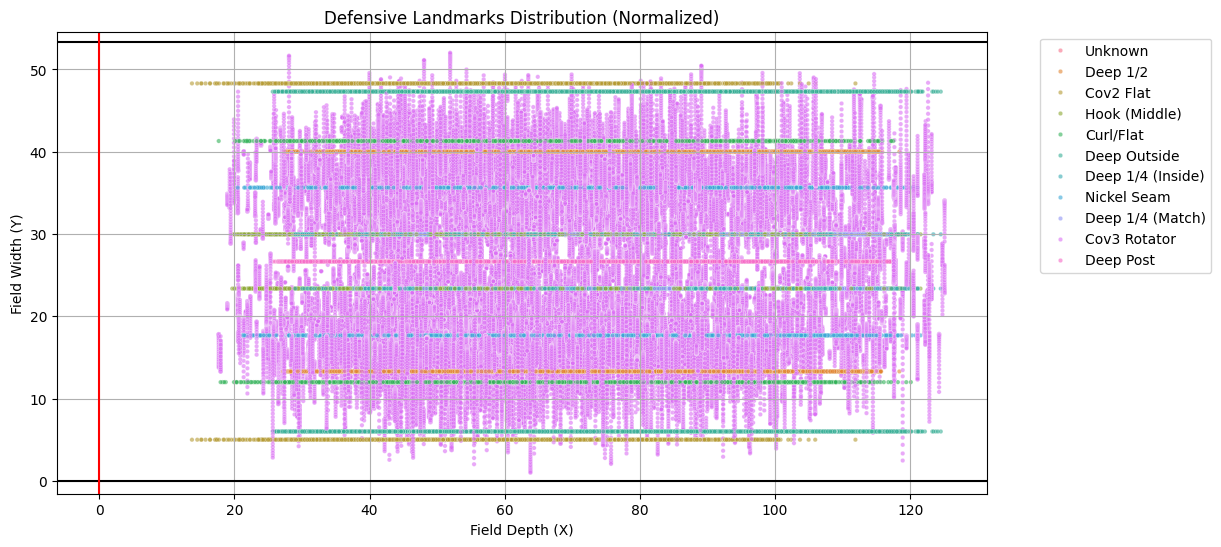

In [4]:
plt.figure(figsize=(12, 6))

# Filter for just the Snap Frame (to see initial assignments) or Pass Arrival
# We use the unique targets assigned
unique_zones = df[['target_zone_x', 'target_zone_y', 'zone_assignment']].drop_duplicates()

sns.scatterplot(
    data=unique_zones, 
    x='target_zone_x', 
    y='target_zone_y', 
    hue='zone_assignment',
    alpha=0.6,
    s=10
)

# Draw the field boundaries
plt.axhline(y=0, color='black') # Sideline
plt.axhline(y=53.3, color='black') # Sideline
plt.axvline(x=0, color='red') # Goal Line
plt.title("Defensive Landmarks Distribution (Normalized)")
plt.xlabel("Field Depth (X)")
plt.ylabel("Field Width (Y)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()

# WHAT TO LOOK FOR:
# 1. Do the dots form "rows"? (Flat defenders shallow, Deep defenders deep).
# 2. Is there a gap in the middle? (No Man's Land).
# 3. Are the "Deep 1/3" dots actually deep?

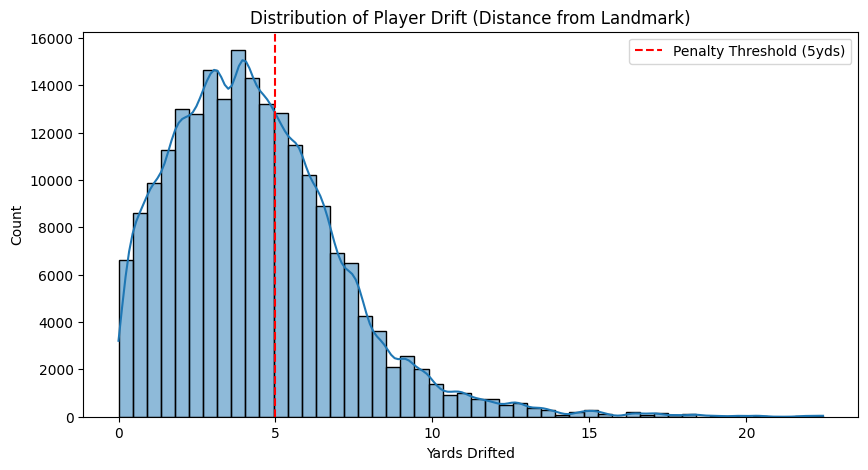

In [5]:
# Filter for only Defensive Coverage players
defenders = df[df['player_role'] == 'Defensive Coverage']

plt.figure(figsize=(10, 5))
sns.histplot(defenders['drift_yards'].dropna(), bins=50, kde=True)
plt.title("Distribution of Player Drift (Distance from Landmark)")
plt.xlabel("Yards Drifted")
plt.axvline(x=5.0, color='red', linestyle='--', label='Penalty Threshold (5yds)')
plt.legend()
plt.show()

# STAT CHECK:
# The curve should peak near 0-2 yards (most players do their job).
# It should have a "Long Tail" to the right (the blown coverages).
# If the peak is at 6 yards, your Landmarks are wrong (systematic error).

/tmp/ipykernel_26074/2155878951.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deep_zones['landmark_depth'] = deep_zones['target_zone_x'] - deep_zones['los_x']


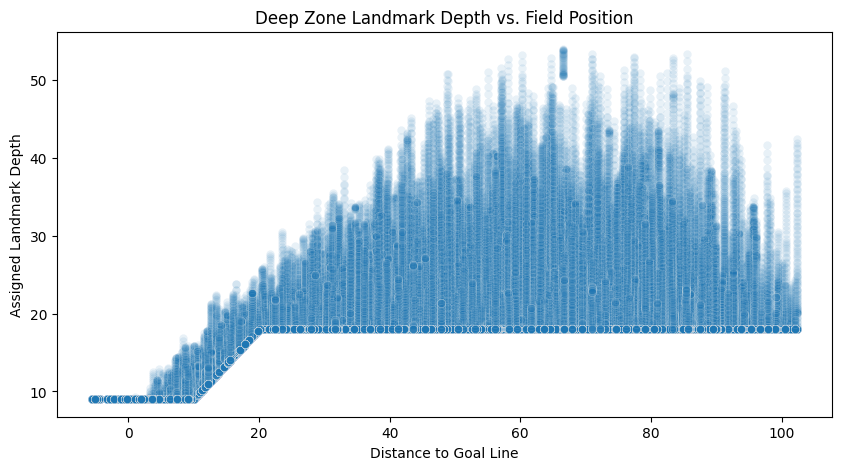

In [6]:
# Calculate distance to goal line (110 is goal line in standardized coords)
df['dist_to_goal'] = 110 - df['los_x']

# Calculate how deep the "Deep 1/2" or "Deep 1/3" landmark was placed relative to LOS
deep_zones = df[df['zone_assignment'].str.contains('Deep')]
deep_zones['landmark_depth'] = deep_zones['target_zone_x'] - deep_zones['los_x']

plt.figure(figsize=(10, 5))
sns.scatterplot(
    data=deep_zones,
    x='dist_to_goal',
    y='landmark_depth',
    alpha=0.1
)
plt.title("Deep Zone Landmark Depth vs. Field Position")
plt.xlabel("Distance to Goal Line")
plt.ylabel("Assigned Landmark Depth")
plt.show()

# WHAT TO LOOK FOR:
# You should see a linear correlation. 
# As 'Distance to Goal' gets smaller (left side of chart), 'Landmark Depth' should get smaller (squashing).
# If it's a flat horizontal line, your Red Zone logic FAILED.

Average EPA per Play:
void_penalty
False    0.194442
True     0.030638
Name: expected_points_added, dtype: float64


/tmp/ipykernel_26074/4250663529.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=epa_stats.index, y=epa_stats.values, palette=['green', 'red'])


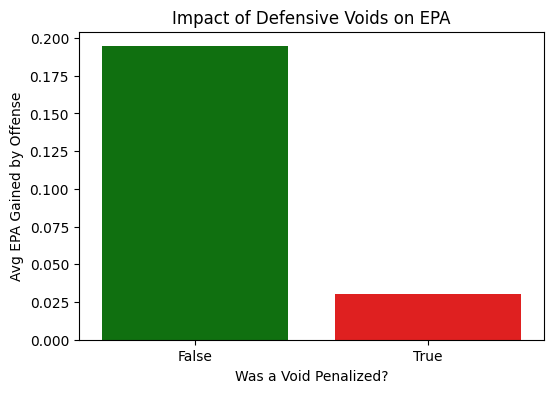

In [7]:
# Get one row per play
play_outcomes = df.drop_duplicates(subset=['game_id', 'play_id'])

# Compare Average EPA for plays WITH a Void vs. WITHOUT
epa_stats = play_outcomes.groupby('void_penalty')['expected_points_added'].mean()

print("Average EPA per Play:")
print(epa_stats)

plt.figure(figsize=(6, 4))
sns.barplot(x=epa_stats.index, y=epa_stats.values, palette=['green', 'red'])
plt.title("Impact of Defensive Voids on EPA")
plt.xlabel("Was a Void Penalized?")
plt.ylabel("Avg EPA Gained by Offense")
plt.show()

# THE GOLDEN STANDARD:
# The 'True' bar (Red) should be significantly higher than the 'False' bar (Green).
# If they are equal, your metric isn't predicting offense success.